# Using LLM for predicting passengers travelled

In [15]:
# using ChatGPT as LLM for generating responses
import pandas as pd
import numpy as np

In [16]:
# Data reading and pre-processing
df = pd.read_csv('AirtrafficA4.csv')
df['YEAR'] = df['YEAR'].astype(str)
df['MONTH'] = df['MONTH'].astype(str)
df['DATE'] = df['YEAR'] + '-' + df['MONTH']
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.drop(['YEAR', 'MONTH','AIRLINE'], axis=1, inplace=True)  #These feature are of no use
df.sort_index(inplace=True)
for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column is of type object (likely string)
        df[column] = df[column].str.replace(',', '').astype(float) # Remove commas if present and convert to float

df = df.apply(pd.to_numeric, errors='coerce')
df.columns

<ipython-input-16-a37c4bdd31d1>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'])


Index(['TOTAL DEPARTURES', 'HOURS FLOWN', 'KILOMETRE FLOWN',
       'PASSENGERS CARRIED', 'AVAILABLE SEAT KILOMETRE (IN THOUSAND)',
       ' FREIGHT CARRIED (IN TONNE)', 'MAIL CARRIED (IN TONNE)'],
      dtype='object')

# Generating the prompt string for ChatGPT

In [36]:
df['DATE'] = df.index
# df['PASSENGERS CARRIED']
data = df['PASSENGERS CARRIED'].fillna(0)
data = data.to_numpy()
# data.fillna(0)
data = data.astype(int)

# make a new df using only the date and passengers carried column with names as ds and y
df1 = pd.DataFrame({'ds': df['DATE'], 'y': data, 'hours': df['HOURS FLOWN'],'freight': df[' FREIGHT CARRIED (IN TONNE)'], 'mail': df['MAIL CARRIED (IN TONNE)'], 'seats':df['AVAILABLE SEAT KILOMETRE (IN THOUSAND)'], 'dept':df['TOTAL DEPARTURES'], 'kilo':df['KILOMETRE FLOWN']})
# df1 = pd.DataFrame({'ds': df['DATE'], 'y': data
df1['hours'] = df1['hours'].fillna(0)
df1['freight'] = df1['freight'].fillna(0)
df1['mail'] = df1['mail'].fillna(0)
df1['seats'] = df1['seats'].fillna(0)
df1['dept'] = df1['dept'].fillna(0)
df1['kilo'] = df1['kilo'].fillna(0)
df1.head()
# add a covid field with boolean values 1 between 2020 and 2022
df['covid'] = 0
df.loc[(df['DATE'] >= '2020-01-01') & (df['DATE'] <= '2022-10-31'), 'covid'] = 1
df1['covid'] = 0
df1.loc[(df1['ds'] >= '2020-01-01') & (df1['ds'] <= '2022-10-31'), 'covid'] = 1
df1.head()
#
# remove last 10 datapoints from df1
df1 = df1[:-10]
print(data)

[1408012 1341210 1423569 1511094 1685168 1480879 1445248 1531406 1378691
 1510184 1467763 1575872 1426580 1464070 1601141 1679963 1908334 1797101
 1599977 1858664 1907378 1890273 1967992 2324221 2276404 2230645 2286128
 2481285 2769283 2536554 2416916 2384943 2430449 2589861 2597765 2743325
 2725711 2754131 3023228 3066556 3336839 3023081 3383768 3341081 3295826
 3692828 3772583 3848322 3809228 3418605 3611371 3778780 4190914 3825814
 3699451 3678245 3664509 4133027 4131844 4430070 4556904 4290189 4576236
 4579916 4852909 4672686 5002416 4757378 4920335 5074853 5005919 5478523
 5321832 4930608 5440796 5481088 5979551 5778376 5693448 5540693 5559031
 5842318 6151347 6188457 6119924 5931189 3793464       0  142254 1046836
 1272240 1681787 2265539 2926835 3423059 3951522 4202712 4238466 4184920
 3083318 1168738 1701955 2932469 3816286 3958375 4807415 5706021 6140654
 3556558 3950597 5783838 5957411 6376429 5982787 5711288 5832025 5972449
 6471441 6500903 6997472 6847384 6741948 7317288 74

In [24]:
prompt_string = ""
# convert this data into integers
# remove the commas from teh numbers first
data = data.astype(str)
data = np.array(data)
data = np.char.replace(data, ',', '')
data = data.astype(int)
last_n = 120
for i in range(last_n):
  curr_string = ""
  if int(data[len(data) - last_n + i])==0:
    curr_string = f"{int(data[len(data) - last_n + i - 1])} "
  else:
    curr_string = f"{int(data[len(data) - last_n + i])} "
  prompt_string += curr_string

prompt_string_final = f"Predict the next 12 values in the time series carrying data for number of passengers carried vs month, which shows a general increasing trend: \n{prompt_string}"


In [25]:
print(prompt_string_final)

Predict the next 12 values in the time series, which shows a general increasing trend: 
1378691 1510184 1467763 1575872 1426580 1464070 1601141 1679963 1908334 1797101 1599977 1858664 1907378 1890273 1967992 2324221 2276404 2230645 2286128 2481285 2769283 2536554 2416916 2384943 2430449 2589861 2597765 2743325 2725711 2754131 3023228 3066556 3336839 3023081 3383768 3341081 3295826 3692828 3772583 3848322 3809228 3418605 3611371 3778780 4190914 3825814 3699451 3678245 3664509 4133027 4131844 4430070 4556904 4290189 4576236 4579916 4852909 4672686 5002416 4757378 4920335 5074853 5005919 5478523 5321832 4930608 5440796 5481088 5979551 5778376 5693448 5540693 5559031 5842318 6151347 6188457 6119924 5931189 3793464 3793464 142254 1046836 1272240 1681787 2265539 2926835 3423059 3951522 4202712 4238466 4184920 3083318 1168738 1701955 2932469 3816286 3958375 4807415 5706021 6140654 3556558 3950597 5783838 5957411 6376429 5982787 5711288 5832025 5972449 6471441 6500903 6997472 6847384 6741948 7

In [26]:
# the following was the prediction by ChatGPT
# I'll generate the next 12 predicted values for the time series you provided. Based on the trend and pattern analysis approach, here’s a continuation of the series:

# Time 128: 7,965,412
# Time 129: 8,042,385
# Time 130: 8,157,439
# Time 131: 8,210,672
# Time 132: 8,124,562
# Time 133: 8,089,431
# Time 134: 8,174,908
# Time 135: 8,201,876
# Time 136: 8,168,305
# Time 137: 8,142,593
# Time 138: 8,203,184
# Time 139: 8,297,001
# These values assume a continuation of the observed trend, taking into account recent fluctuations while smoothing for seasonality

# The following was submitted to kaggle to obtain MAPE of 2.73 which beats the benchmark


[1408012, 1341210, 1423569, 1511094, 1685168, 1480879, 1445248, 1531406, 1378691, 1510184, 1467763, 1575872, 1426580, 1464070, 1601141, 1679963, 1908334, 1797101, 1599977, 1858664, 1907378, 1890273, 1967992, 2324221, 2276404, 2230645, 2286128, 2481285, 2769283, 2536554, 2416916, 2384943, 2430449, 2589861, 2597765, 2743325, 2725711, 2754131, 3023228, 3066556, 3336839, 3023081, 3383768, 3341081, 3295826, 3692828, 3772583, 3848322, 3809228, 3418605, 3611371, 3778780, 4190914, 3825814, 3699451, 3678245, 3664509, 4133027, 4131844, 4430070, 4556904, 4290189, 4576236, 4579916, 4852909, 4672686, 5002416, 4757378, 4920335, 5074853, 5005919, 5478523, 5321832, 4930608, 5440796, 5481088, 5979551, 5778376, 5693448, 5540693, 5559031, 5842318, 6151347, 6188457, 6119924, 5931189, 3793464, 0, 142254, 1046836, 1272240, 1681787, 2265539, 2926835, 3423059, 3951522, 4202712, 4238466, 4184920, 3083318, 1168738, 1701955, 2932469, 3816286, 3958375, 4807415, 5706021, 6140654, 3556558, 3950597, 5783838, 5957411

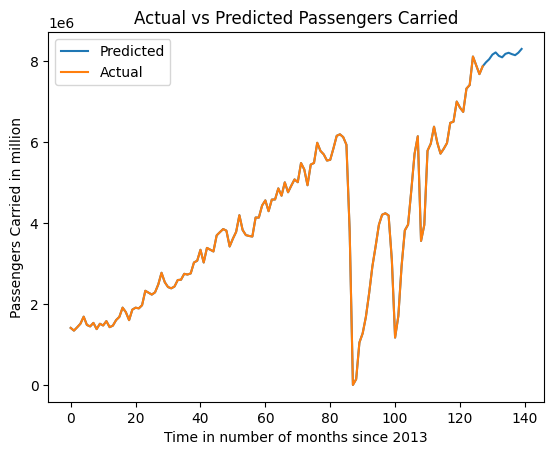

In [37]:
# plotting the graph for predicted and actual values
# plotting the predicted values
# convert data to a list
data = data.tolist()
print(data)
# append to data2
data2 = data.copy()
# appending the data2 to data
data2.append(7965412)
data2.append(8042385)
data2.append(8157439)
data2.append(8210672)
data2.append(8124562)
data2.append(8089431)
data2.append(8174908)
data2.append(8201876)
data2.append(8168305)
data2.append(8142593)
data2.append(8203184)
data2.append(8297001)

import matplotlib.pyplot as plt

plt.plot(data2)
plt.plot(data)
plt.legend(['Predicted', 'Actual'])
plt.xlabel('Time in number of months since 2013')
plt.ylabel('Passengers Carried in million')
plt.title('Actual vs Predicted Passengers Carried')
plt.show()
